In [1]:
import torch
import esm
import pickle
import random
from collections import Counter
from tqdm import tqdm
from datetime import datetime
from Bio import AlignIO, SeqIO
import plotly.express as px

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

In [ ]:
def read_fasta_to_df(fasta_file, seq_header):   # We are going to ignore/remove all the other info like name and stuff from the fasta, just the id
    df = pd.DataFrame.from_records([item.__dict__ for item in SeqIO.parse(fasta_file, format='fasta')])
    df[seq_header] = df.apply(lambda x: ''.join(x['_seq']), axis=1)
    df = df.drop(columns=['_seq', 'name', 'description', 'dbxrefs', 'annotations', '_per_letter_annotations', 'features'])
    return(df)

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

def make_tSNE(input_df, embedding_col, id_col, perplexity=30):
    cosine_dist_matrix = pairwise_distances(np.stack(input_df[embedding_col].values), metric="cosine")
    tsne = TSNE(n_components=2, metric="precomputed", init="random", random_state=42, perplexity=perplexity)
    tsne_out = tsne.fit_transform(cosine_dist_matrix)

    df_tsne = pd.DataFrame(tsne_out, columns=['Dim1', 'Dim2'])
    df_tsne['LSU_SSU_id'] = input_df[id_col].to_list()
    df_tsne = df_tsne.fillna(0)

    df_out = pd.merge(input_df, df_tsne, on=[id_col])

    return(df_out)

In [4]:
pretrained_arg = esm.pretrained.esm2_t33_650M_UR50D() ## For ESM-1b: `esm1_t34_670M_UR50S`; ESM-2: `esm2_t33_650M_UR50D()`
layers = 33 ## For ESM-1b: 34; ESM-2: 33

model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model.eval()
batch_converter = alphabet.get_batch_converter()
model = model.to(torch.device('cuda:0'))

def compute_embedding(key, value):
    inp = [(key, value)]
    batch_labels, batch_strs, batch_tokens = batch_converter(inp)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    batch_tokens = batch_tokens.to(torch.device('cuda:0'))
    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[layers])
        
    token_representations = results["representations"][layers]
    # return token_representations[0, 0]
    return token_representations[0, 1 : batch_lens[0] - 1].mean(0)

## Making predictions for the Lanster 2024 Fig. 5 (5C specifically) -- 43 extant sequences from Form-II & II/III

In [5]:
lanster_form_II_III_extant_activity_5C = pd.read_csv("/home/kaustubh/RuBisCO_ML/regressor_models/data/Lanster_2024_extant_data/mScarlet-I_only_data_Fig5C.csv")
lanster_form_II_III_extant_activity_5C[["kcat", "kcat_err", "rep_1", "rep_2", "rep_3", "rep_4"]] = lanster_form_II_III_extant_activity_5C[["kcat", "kcat_err", "rep_1", "rep_2", "rep_3", "rep_4"]].apply(pd.to_numeric, errors='coerce')
lanster_form_II_III_extant_activity_5C['rep_mean'] = lanster_form_II_III_extant_activity_5C[["rep_1", "rep_2", "rep_3", "rep_4"]].mean(axis=1)
lanster_form_II_III_extant_activity_5C['rep_std'] = lanster_form_II_III_extant_activity_5C[["rep_1", "rep_2", "rep_3", "rep_4"]].std(axis=1)

lanster_form_II_III_extant_seqs = read_fasta_to_df("/home/kaustubh/RuBisCO_ML/regressor_models/data/Lanster_2024_extant_data/seqs.fasta", "LSU_seq")
lanster_form_II_III_extant_seqs.rename(columns={"id": "uniprot_id"}, inplace=True)
lanster_form_II_III_extant_seqs['id'] = lanster_form_II_III_extant_seqs['uniprot_id'].apply(lambda x: x.split(".")[0])

lanster_form_II_III_extant_df = pd.merge(lanster_form_II_III_extant_activity_5C, lanster_form_II_III_extant_seqs[["LSU_seq", "id"]], on='id')
lanster_form_II_III_extant_df['lsu_esm'] = lanster_form_II_III_extant_df.apply(lambda x: compute_embedding(x['id'], x['LSU_seq']).cpu().numpy() if pd.notna(x['LSU_seq']) else np.nan, axis=1)
lanster_form_II_III_extant_df

,id,kcat,kcat_err,rep_1,rep_2,rep_3,rep_4,rep_mean,rep_std,LSU_seq,lsu_esm
0,AAV98336,6.6,0.3,903.7,954.4,1024.0,1010.8,973.225000,55.311504,MSPQTETKASVGFKHMDQSSRYVNLALKEEDLIAGGEHVLCAYIMK...,"[0.007667688, -0.0017555519, -0.021776926, 0.0..."
1,WP_076365084,6.4,2.9,282.0,230.0,346.2,207.4,266.400000,61.691058,MDQSNRYARLDLNEDELMAGGKHVLVAYIMKPKAGYGFLETAAHFA...,"[0.021141285, -0.0020539635, -0.006559981, 0.0..."
2,WP_073240254,1.2,0.6,210.5,243.0,148.5,226.0,207.000000,41.196683,MAFLYNQSSRYINLDLKEKELIDGGKHVLCAYIMKPKQGFGHMEVA...,"[0.028448356, 0.008163204, -0.0078443345, 0.01..."
3,WP_068501953,7.3,1.9,231.8,270.8,304.5,35.7,210.700000,120.389174,MDQSKRYCNFALKEDELIAAGRHVLCAYIIKPKAGYEPISTAAHFA...,"[0.010125615, 0.0021618174, -0.011941692, 0.00..."
4,WP_013720421,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIQEELSKTLNPKQVQYMRMDLPDPRNGEYLLAVFHLIPSGELNIM...,"[0.011285836, 0.062602356, -0.0038658215, -0.0..."
5,AAV98336_K191M,0.0,NaN,9.0,5.0,9.0,9.0,8.000000,2.000000,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...,"[0.01137117, -0.00058704487, -0.020185864, 0.0..."
6,OIO73685,13.1,2.5,NaN,NaN,NaN,NaN,NaN,NaN,MDQSNRYADLSLNEADLIAGGKHLLVAYKLIPAKGYGFLEVAAHIA...,"[0.013496176, 0.03473968, -0.006018055, 0.0193..."
7,WP_018289723,3.9,NaN,290.2,367.2,319.3,347.9,331.150000,33.652588,MAYDQSHRYSNLKLEEARLIAEGNHVLCTYRLQPKPGHGFLATAAH...,"[-0.005768631, 0.02043374, -0.012907777, -0.02..."
8,OGT90264,9.4,1.4,451.8,536.5,363.6,377.3,432.300000,79.545752,MALDQSSRYADLNLKEEDLIAGGKHILCAYKMKPKAGTGYLEAAAH...,"[0.015279714, 0.017076485, -0.026116427, 0.016..."
9,WP_009453497,5.7,0.3,675.2,579.6,517.2,457.0,557.250000,93.212642,MDQSSRYADLSLNEQDLMQGGRHILVAYKMKPKAGHGYLEAAAHFA...,"[0.021792222, 0.0032114545, -0.027460288, 0.02..."


### Loading the regressor

In [8]:
## Loading the model for the split of combined dataset
with open("/home/kaustubh/RuBisCO_ML/regressor_models/data/regressor_output/normalized_wrt_ind_ancs/ESM-2_log_large_mutant_data_split/grid_element_best_MLPRegressor_model.pkl", "rb") as f1:
    combined_MLP_regressor_model = pickle.load(f1)

## Loading the model for the large-mutant dataset split approach
with open("/home/kaustubh/RuBisCO_ML/regressor_models/data/regressor_output/normalized_wrt_ind_ancs/ESM-2_log_all_data_split/grid_element_best_SVR_model.pkl", "rb") as f2:
    train_large_SVR_regressor_model = pickle.load(f2)

with open("/home/kaustubh/RuBisCO_ML/regressor_models/data/regressor_output/normalized_wrt_ind_ancs/ESM-2_log_all_data_split/grid_element_best_MLPRegressor_model.pkl", "rb") as f3:
    train_mutant_MLP_regressor_model = pickle.load(f3)

### Making the predictions

In [9]:
headers_lanster = []
embeddings_lanster = []

for i, row in lanster_form_II_III_extant_df.iterrows():
    header = row['id']
    headers_lanster.append(header)
    embeddings = row['lsu_esm']
    embeddings_lanster.append(embeddings)
    
preds_lanster_seqs_combined = combined_MLP_regressor_model.predict(embeddings_lanster)
preds_lanster_seqs_train_large = train_large_SVR_regressor_model.predict(embeddings_lanster)
preds_lanster_seqs_train_mutant = train_mutant_MLP_regressor_model.predict(embeddings_lanster)

preds_lanster_seqs = pd.DataFrame({
    'id': headers_lanster,
    'Predicted_Activity_combined': preds_lanster_seqs_combined,
    'Predicted_Activity_train_large': preds_lanster_seqs_train_large,
    'Predicted_Activity_train_mutant': preds_lanster_seqs_train_mutant
})
preds_lanster_seqs

,id,Predicted_Activity_combined,Predicted_Activity_train_large,Predicted_Activity_train_mutant
0,AAV98336,1.870594,2.051192,2.365512
1,WP_076365084,3.213181,3.594673,4.385427
2,WP_073240254,1.592352,2.452823,2.451143
3,WP_068501953,1.538717,2.006741,2.449772
4,WP_013720421,2.510631,2.396605,2.317667
5,AAV98336_K191M,1.515676,2.177059,2.460209
6,OIO73685,1.490402,1.385735,1.171341
7,WP_018289723,1.489178,2.042918,1.743659
8,OGT90264,3.308350,3.211088,2.988139
9,WP_009453497,3.346744,3.403897,3.434799


In [21]:
lanster_form_II_III_extant_df = pd.merge(lanster_form_II_III_extant_df, preds_lanster_seqs)
lanster_form_II_III_extant_df.dropna(subset=['kcat', 'rep_mean'], inplace=True)

Text(0.5, 1.0, 'Train -- Mutant dataset & Test -- Large dataset')

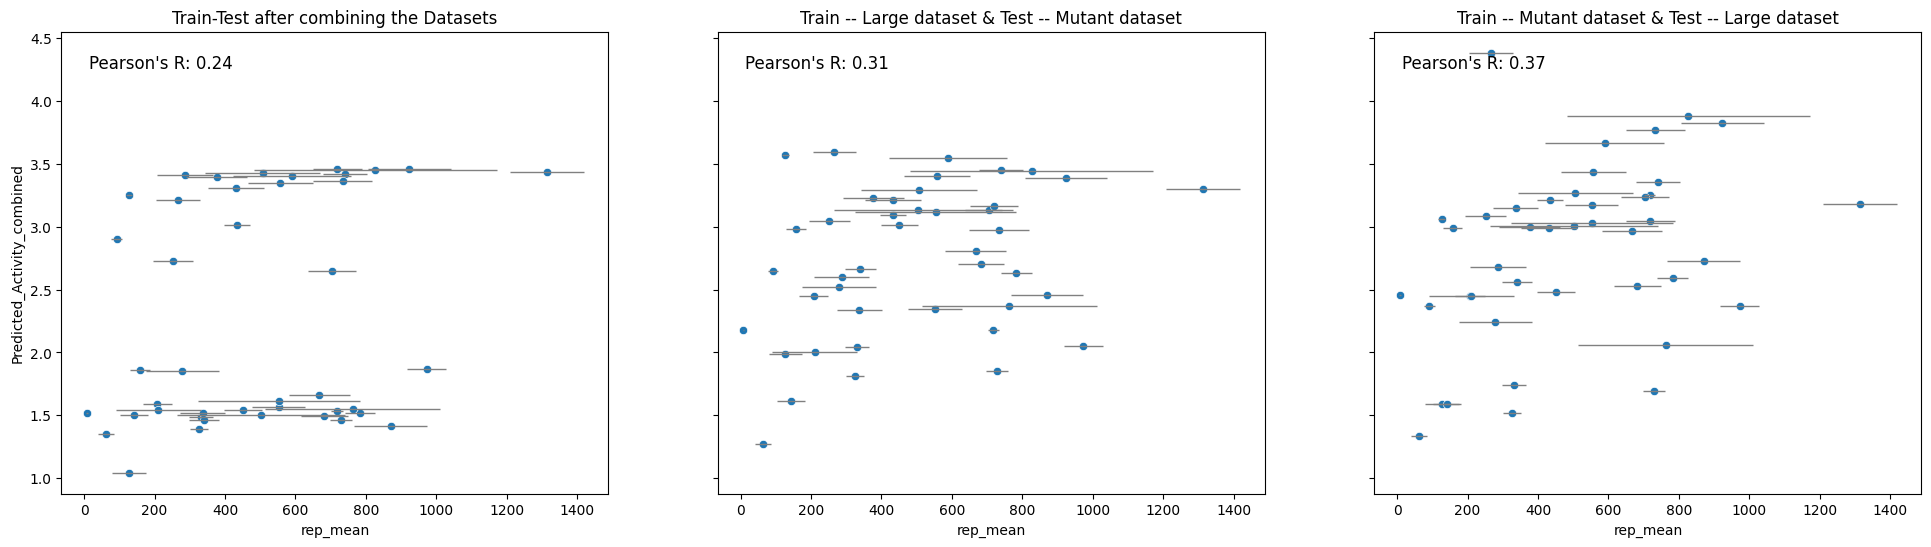

In [24]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(24, 6))

r1, p1 = scipy.stats.pearsonr(lanster_form_II_III_extant_df['rep_mean'], lanster_form_II_III_extant_df['Predicted_Activity_combined'])
r2, p2 = scipy.stats.pearsonr(lanster_form_II_III_extant_df['rep_mean'], lanster_form_II_III_extant_df['Predicted_Activity_train_large'])
r3, p3 = scipy.stats.pearsonr(lanster_form_II_III_extant_df['rep_mean'], lanster_form_II_III_extant_df['Predicted_Activity_train_mutant'])

sns.scatterplot( data=lanster_form_II_III_extant_df, x='rep_mean', y='Predicted_Activity_combined', ax=ax[0])
sns.scatterplot( data=lanster_form_II_III_extant_df, x='rep_mean', y='Predicted_Activity_train_large', ax=ax[1])
sns.scatterplot( data=lanster_form_II_III_extant_df, x='rep_mean', y='Predicted_Activity_train_mutant', ax=ax[2])

ax[0].errorbar( lanster_form_II_III_extant_df['rep_mean'], lanster_form_II_III_extant_df['Predicted_Activity_combined'], xerr=lanster_form_II_III_extant_df['rep_std'], fmt='none', ecolor='gray', elinewidth=1) 
ax[1].errorbar( lanster_form_II_III_extant_df['rep_mean'], lanster_form_II_III_extant_df['Predicted_Activity_train_large'], xerr=lanster_form_II_III_extant_df['rep_std'], fmt='none', ecolor='gray', elinewidth=1) 
ax[2].errorbar( lanster_form_II_III_extant_df['rep_mean'], lanster_form_II_III_extant_df['Predicted_Activity_train_mutant'], xerr=lanster_form_II_III_extant_df['rep_std'], fmt='none', ecolor='gray', elinewidth=1) 

ax[0].annotate(f"Pearson's R: {rho1:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top')
ax[1].annotate(f"Pearson's R: {rho2:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top')
ax[2].annotate(f"Pearson's R: {rho3:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top')

ax[0].set_title('Train-Test after combining the Datasets')
ax[1].set_title('Train -- Large dataset & Test -- Mutant dataset')
ax[2].set_title('Train -- Mutant dataset & Test -- Large dataset')

## Making predictions for the CbbM point mutants

In [ ]:
cbbm_point_mutants = pd.read_csv("/home/kaustubh/RuBisCO_ML/regressor_models/data/Lanster_2024_extant_data/cbbM_point_mutants.csv")
cbbm_point_mutants.columns = ['id', 'relative_rate', 'rep_1', 'rep_2', 'rep_3']
cbbm_point_mutants['seq'] = "MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFAAESSTGTNVEVCTTDDFTRGVDALVYEVDEARELTKIAYPVALFDRNITDGKAMIASFLTLTMGNNQGMGDVEYAKMHDFYVPEAYRALFDGPSVNISALWKVLGRPEVDGGLVVGTIIKPKLGLRPKPFAEACHAFWLGGDFIKNDEPQGNQPFAPLRDTIALVADAMRRAQDETGEAKLFSANITADDPFEIIARGEYVLETFGENASHVALLVDGYVAGAAAITTARRRFPDNFLHYHRAGHGAVTSPQSKRGYTAFVHCKMARLQGASGIHTGTMGFGKMEGESSDRAIAYMLTQDEAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTAGGGAFGHIDGPVAGARSLRQAWQAWRDGVPVLDYAREHKELARAFESFPGDADQIYPGWRKALGVEDTRSALPA"
cbbm_point_mutants['seq'] = cbbm_point_mutants.apply(lambda x: x['seq'].replace("X", ""))

,id,relative_rate,rep_1,rep_2,rep_3,seq
0,wt(AAV98336),1.0000,1.667622,0.772133,0.560245,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...
1,D188E,0.8136,0.478042,1.472741,1.425588,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...
2,D117V,0.6016,0.434104,1.100197,1.278390,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...
3,H44Q,0.7561,0.945475,0.555842,0.941768,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...
4,H44N,0.7967,0.996460,0.924111,1.220841,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...
5,K122R,0.6900,0.453293,0.433187,0.658427,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...
6,T53S,0.5800,0.548076,0.892169,0.506136,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...
7,H291A,0.4000,1.056387,0.344686,0.371507,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...
8,G394A,0.3500,0.560579,0.553110,0.315222,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...
9,N54A,0.2200,0.759645,0.999008,0.676575,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...
